In [1]:
%matplotlib inline
import logging

import os
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from glob import glob
import wandb

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, RandomCrop

from tqdm import tqdm
from sklearn.manifold import TSNE
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


import torchvision
import umap
from cycler import cycler

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.1.2


In [2]:
path = '/var/scratch/mxiao/data/'
os.chdir(path)

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
# Set the image transforms
normalize = transforms.Normalize(mean=[0.6195012,0.6195012,0.6195012], std=[0.3307451,0.3307451,0.3307451])
# normalize = transforms.Normalize(mean=[0.53997546,0.53997546,0.53997546], std=[0.36844322,0.36844322,0.36844322])

train_transform = transforms.Compose([
#         transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.Resize(224),             # resize shortest side to 224 pixels
#         transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.RandomCrop(size=(224,224),pad_if_needed=True), 
        transforms.ToTensor(),
        normalize
    ])

test_transform = transforms.Compose([
        transforms.RandomCrop((224,224),pad_if_needed=True),
        transforms.ToTensor(),
        normalize
    ])

In [18]:
batch_size = 32

dataset1 = datasets.ImageFolder(root=("model/train"),transform=train_transform)
dataset2 = datasets.ImageFolder(root=("model/test"),transform=test_transform)

class_dict = {i: class_name for i, class_name in enumerate(dataset1.classes)}

In [5]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# Resnet
# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet50(pretrained=True).to(device)
trunk_output_size = trunk.fc.in_features
trunk.fc = nn.Identity()

In [10]:
trunk_output_size

2048

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, len(class_dict)]).to(device))

# # We'll specify the classification loss further down in the code.
# classifier = torch.nn.DataParallel(MLP([1024, len(class_dict)])).to(device)

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.0001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(
    embedder.parameters(), lr=0.0001, weight_decay=0.0001
)
# classifier_optimizer = torch.optim.Adam(
#     classifier.parameters(), lr=0.0001, weight_decay=0.0001
# )

In [43]:
models = {"trunk": trunk, "embedder": embedder}
models

{'trunk': DataParallel(
   (module): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downsa

In [14]:
# train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=False, num_workers=4)

In [44]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# # Set the classification loss:
# classification_loss = torch.nn.CrossEntropyLoss()

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# miner = miners.TripletMarginMiner(
#     margin=0.2, distance=distance, type_of_triplets="hard"
# )

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    dataset1.targets, m=4, length_before_new_iter=len(dataset1)
)

# Set other training parameters
num_epochs = 40

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer
}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

# We can specify loss weights if we want to. This is optional
# loss_weights = {"metric_loss": 1, "classifier_loss": 0.5}

In [11]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs_res101_0001lr/ example_tensorboard_res101_0001lr/

In [45]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "logs_res50_0001lr_metric_only_mapr", "tensorboard_res50_0001lr_metric_only_mapr"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": dataset2}
model_folder = "PML_v13"
#v3:resnet50-no_augmentation
#v4:resnet50-augmentation
#v5:efficientnet b0-no augmentation
#v6:resnet101-no_augmentation 0.0001lr

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()


# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=4,
    accuracy_calculator=AccuracyCalculator(include=("mean_average_precision_at_r",), k='max_bin_count'),
)

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=1
)

In [46]:
# trainer = trainers.TrainWithClassifier(
#     models,
#     optimizers,
#     batch_size,
#     loss_funcs,
#     dataset1,
#     mining_funcs=mining_funcs,
#     sampler=sampler,
#     dataloader_num_workers=4,
#     loss_weights=loss_weights,
#     end_of_iteration_hook=hooks.end_of_iteration_hook,
#     end_of_epoch_hook=end_of_epoch_hook,
# )

trainer = trainers.MetricLossOnly(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    dataset1,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=4,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

In [39]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir tensorboard_res50_0001lr_metric_only_mapr
# %tensorboard --logdir=./logs --host localhost

Reusing TensorBoard on port 6007 (pid 17897), started 0:00:51 ago. (Use '!kill 17897' to kill it.)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.12800: 100%|███████████████████████████████████████████████████████████| 1028/1028 [06:08<00:00,  2.79it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:00<00:00,  9.23it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


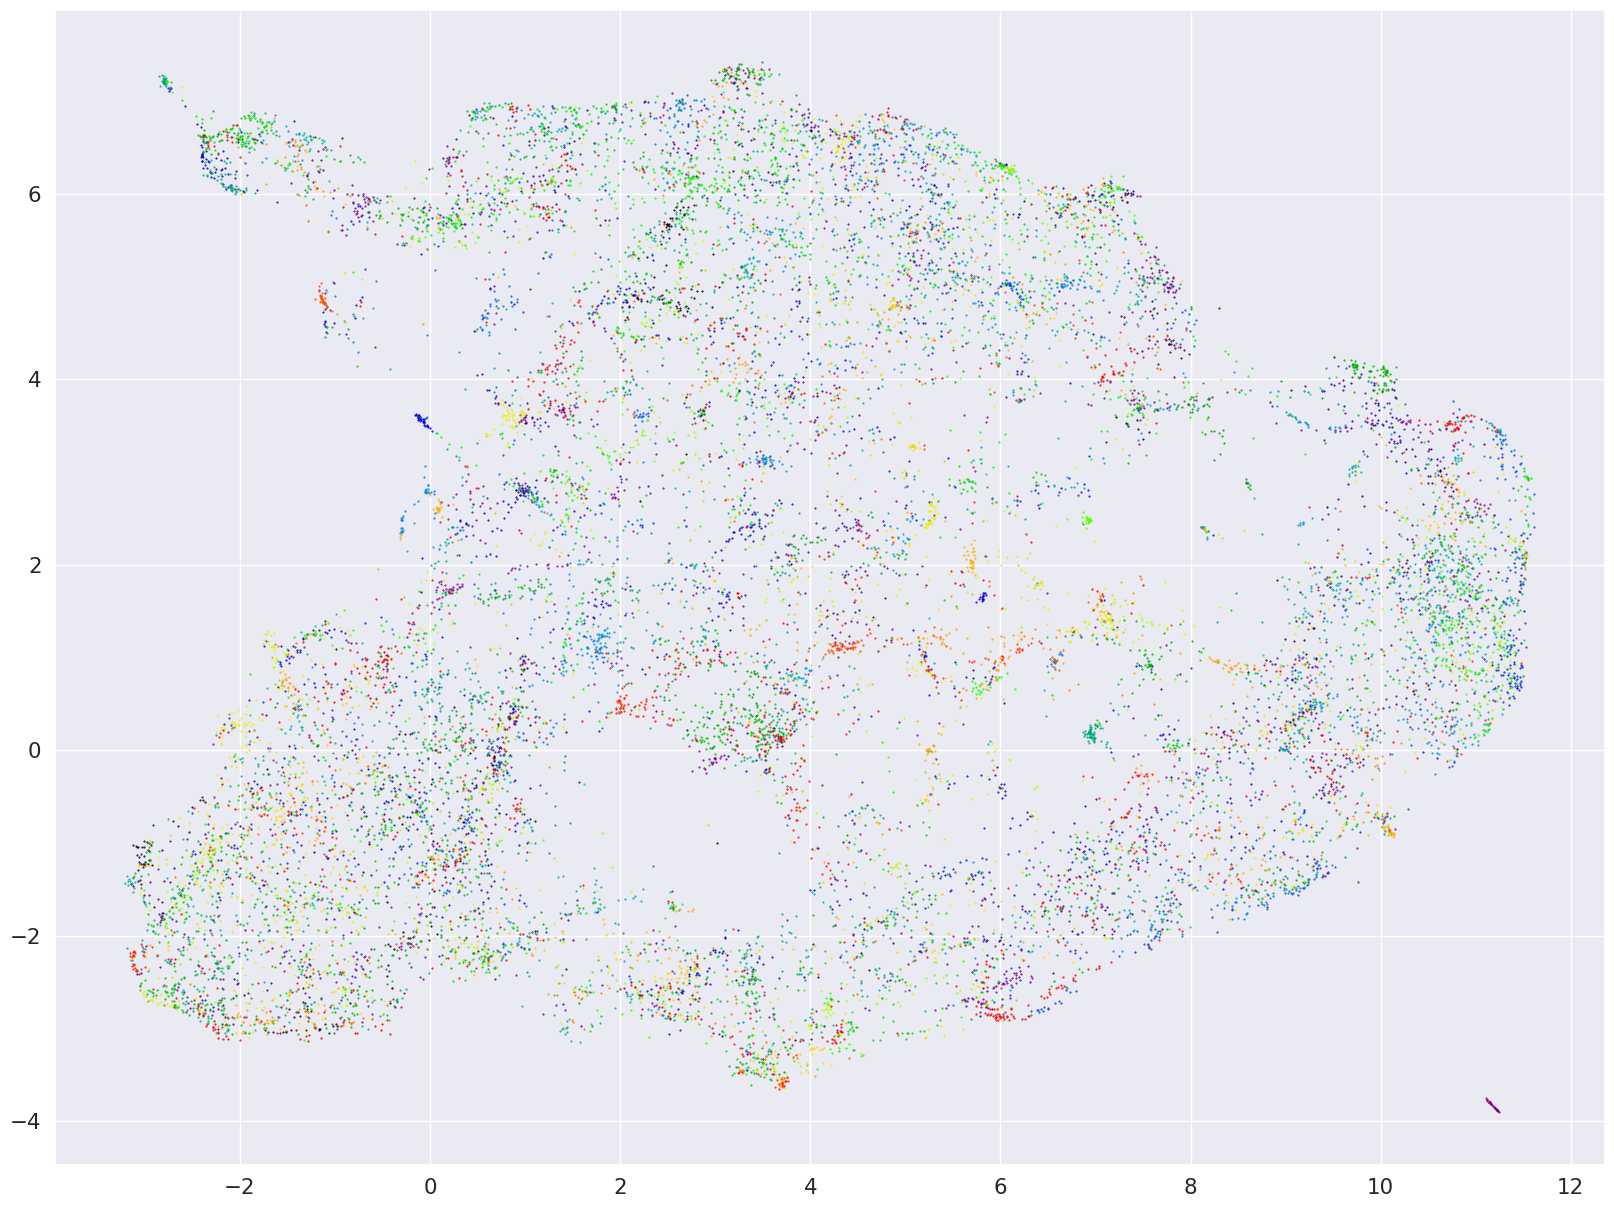

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.12945342751678796
INFO:PML:TRAINING EPOCH 2
total_loss=0.11301: 100%|███████████████████████████████████████████████████████████| 1028/1028 [06:48<00:00,  2.52it/s]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.36it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


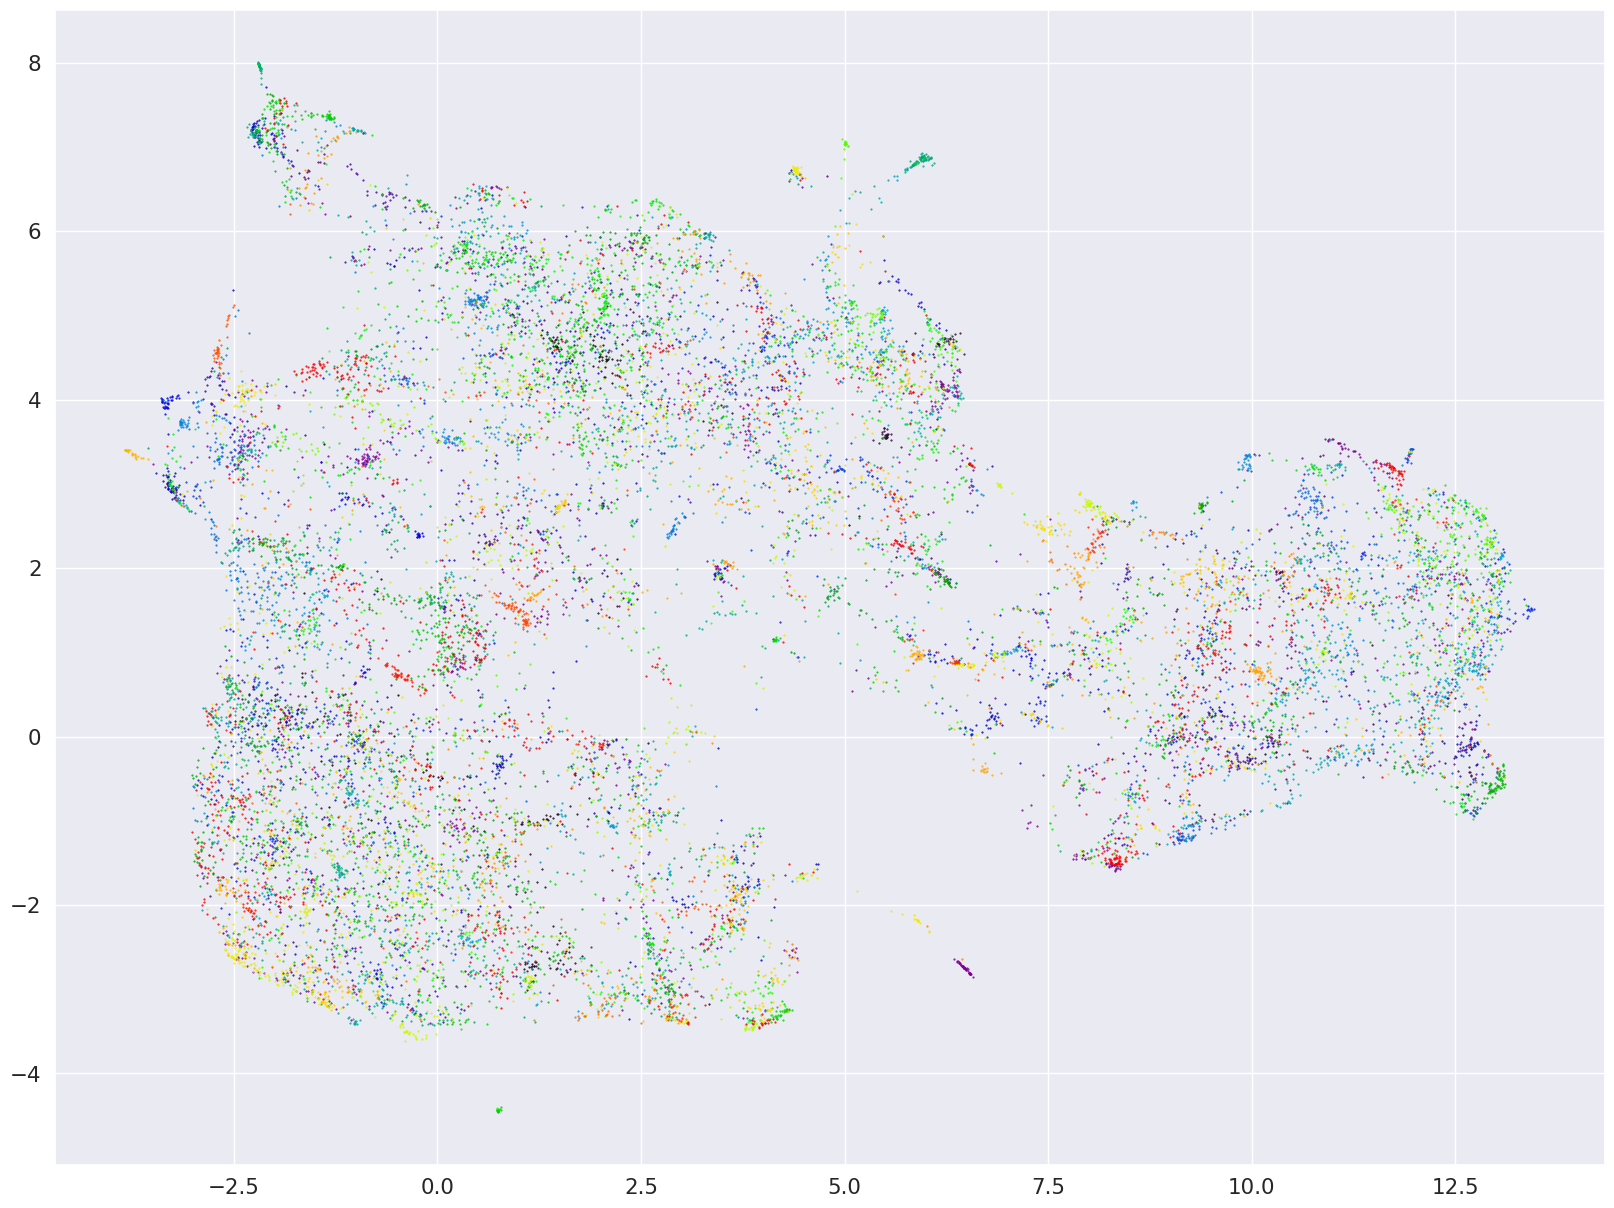

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.1541995596539978
INFO:PML:TRAINING EPOCH 3
total_loss=0.09950: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:52<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.38it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


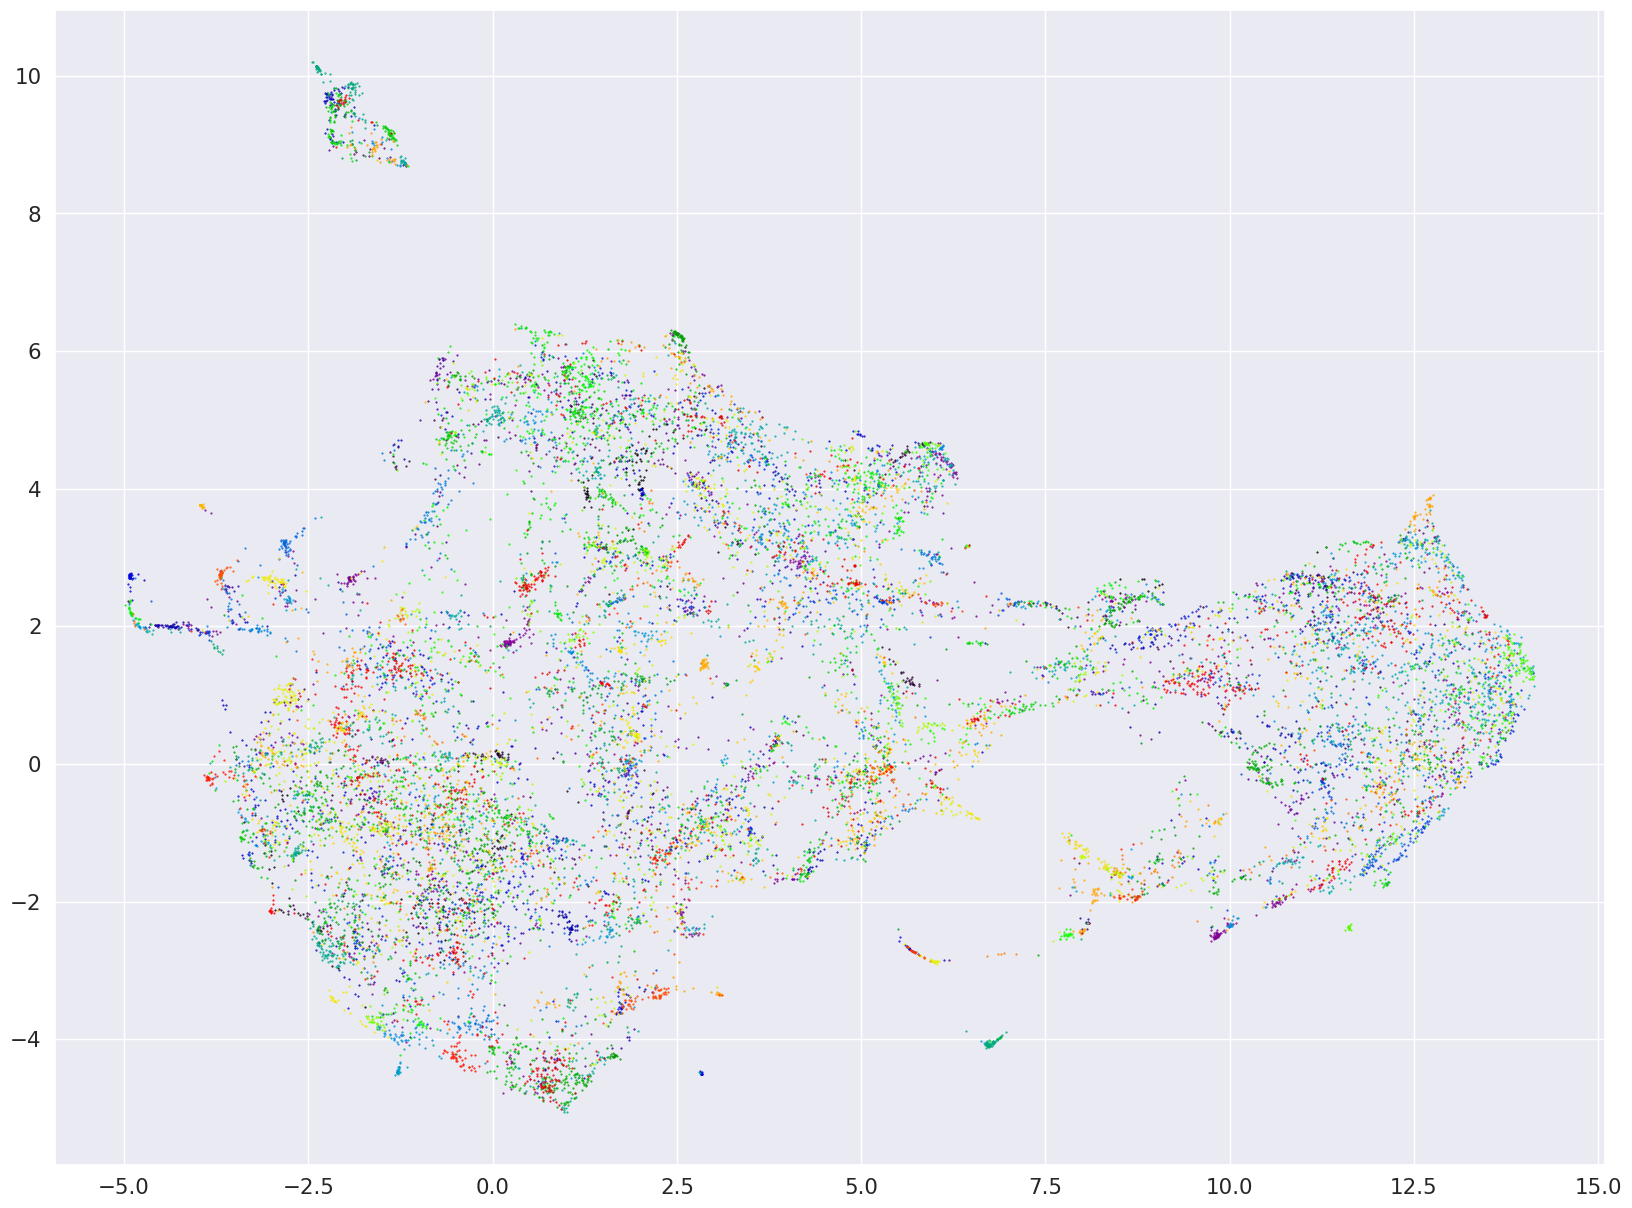

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.1669300902205475
INFO:PML:TRAINING EPOCH 4
total_loss=0.12104: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:45<00:00,  5.34it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


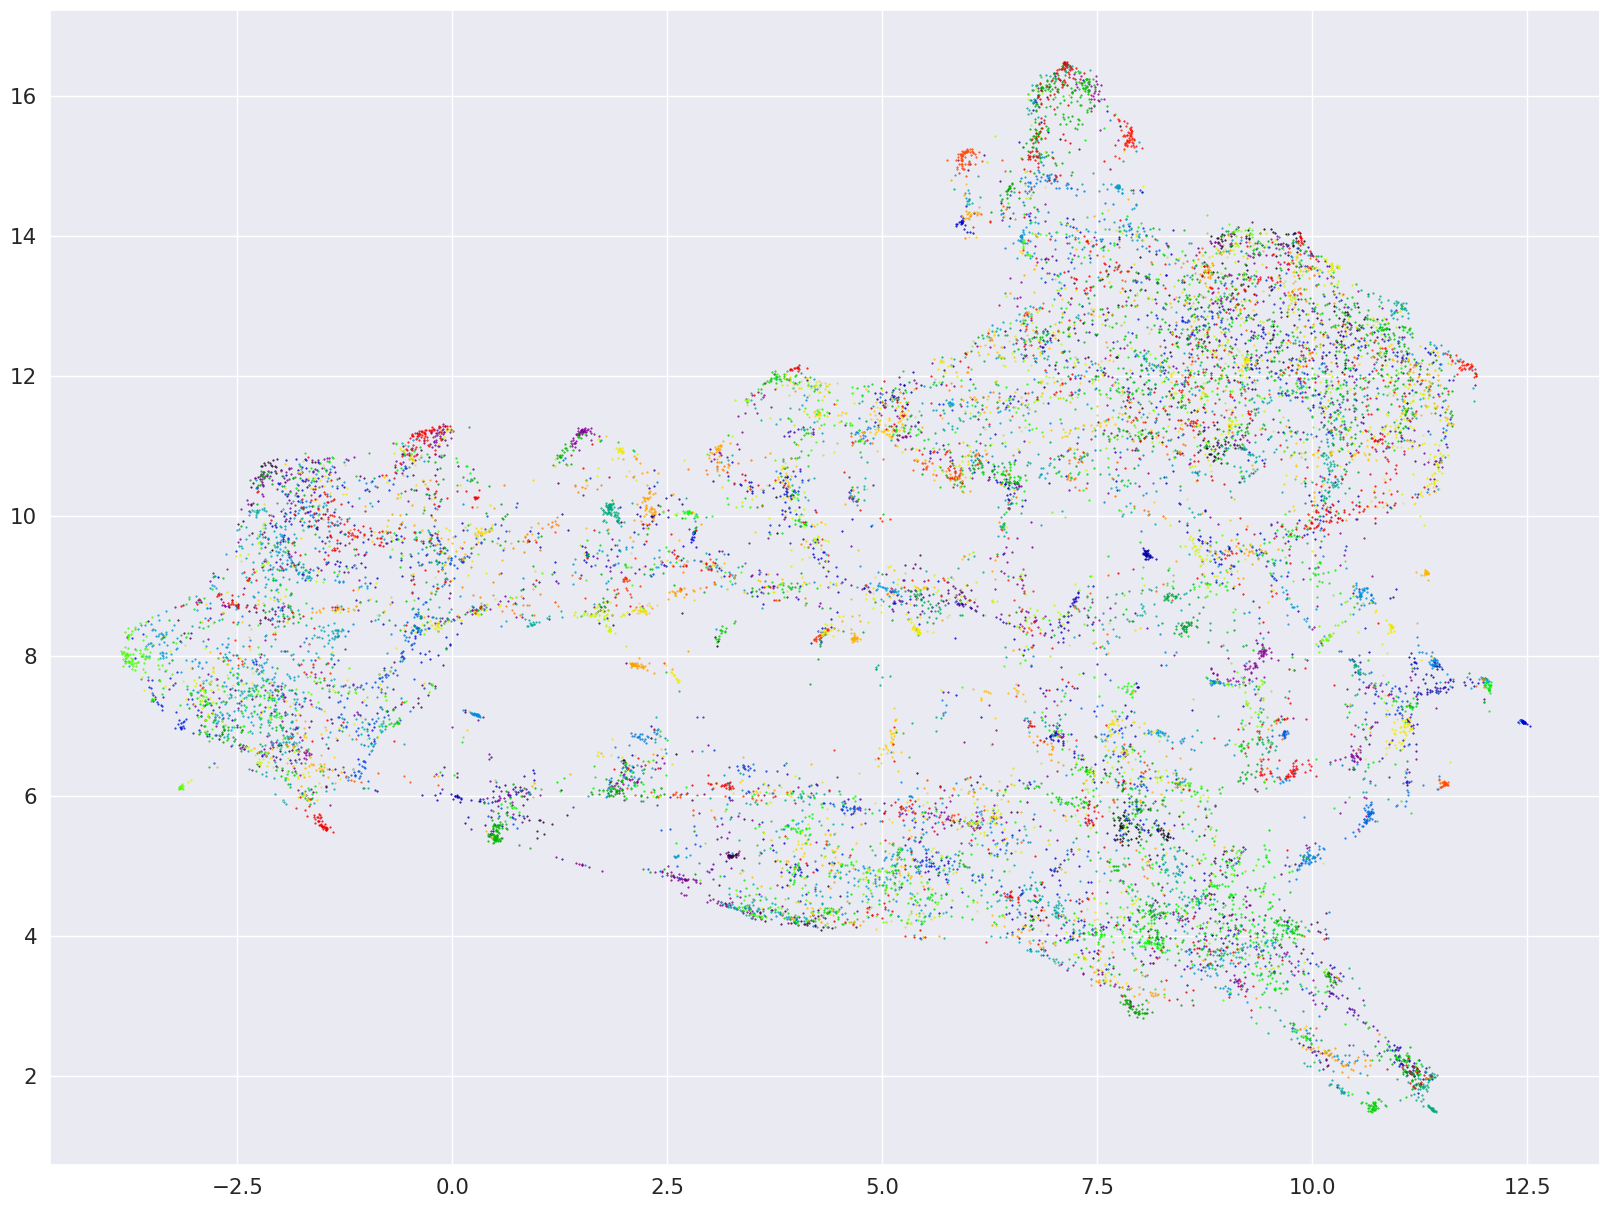

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.17748158307999473
INFO:PML:TRAINING EPOCH 5
total_loss=0.07788: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 5
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:45<00:00,  5.35it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


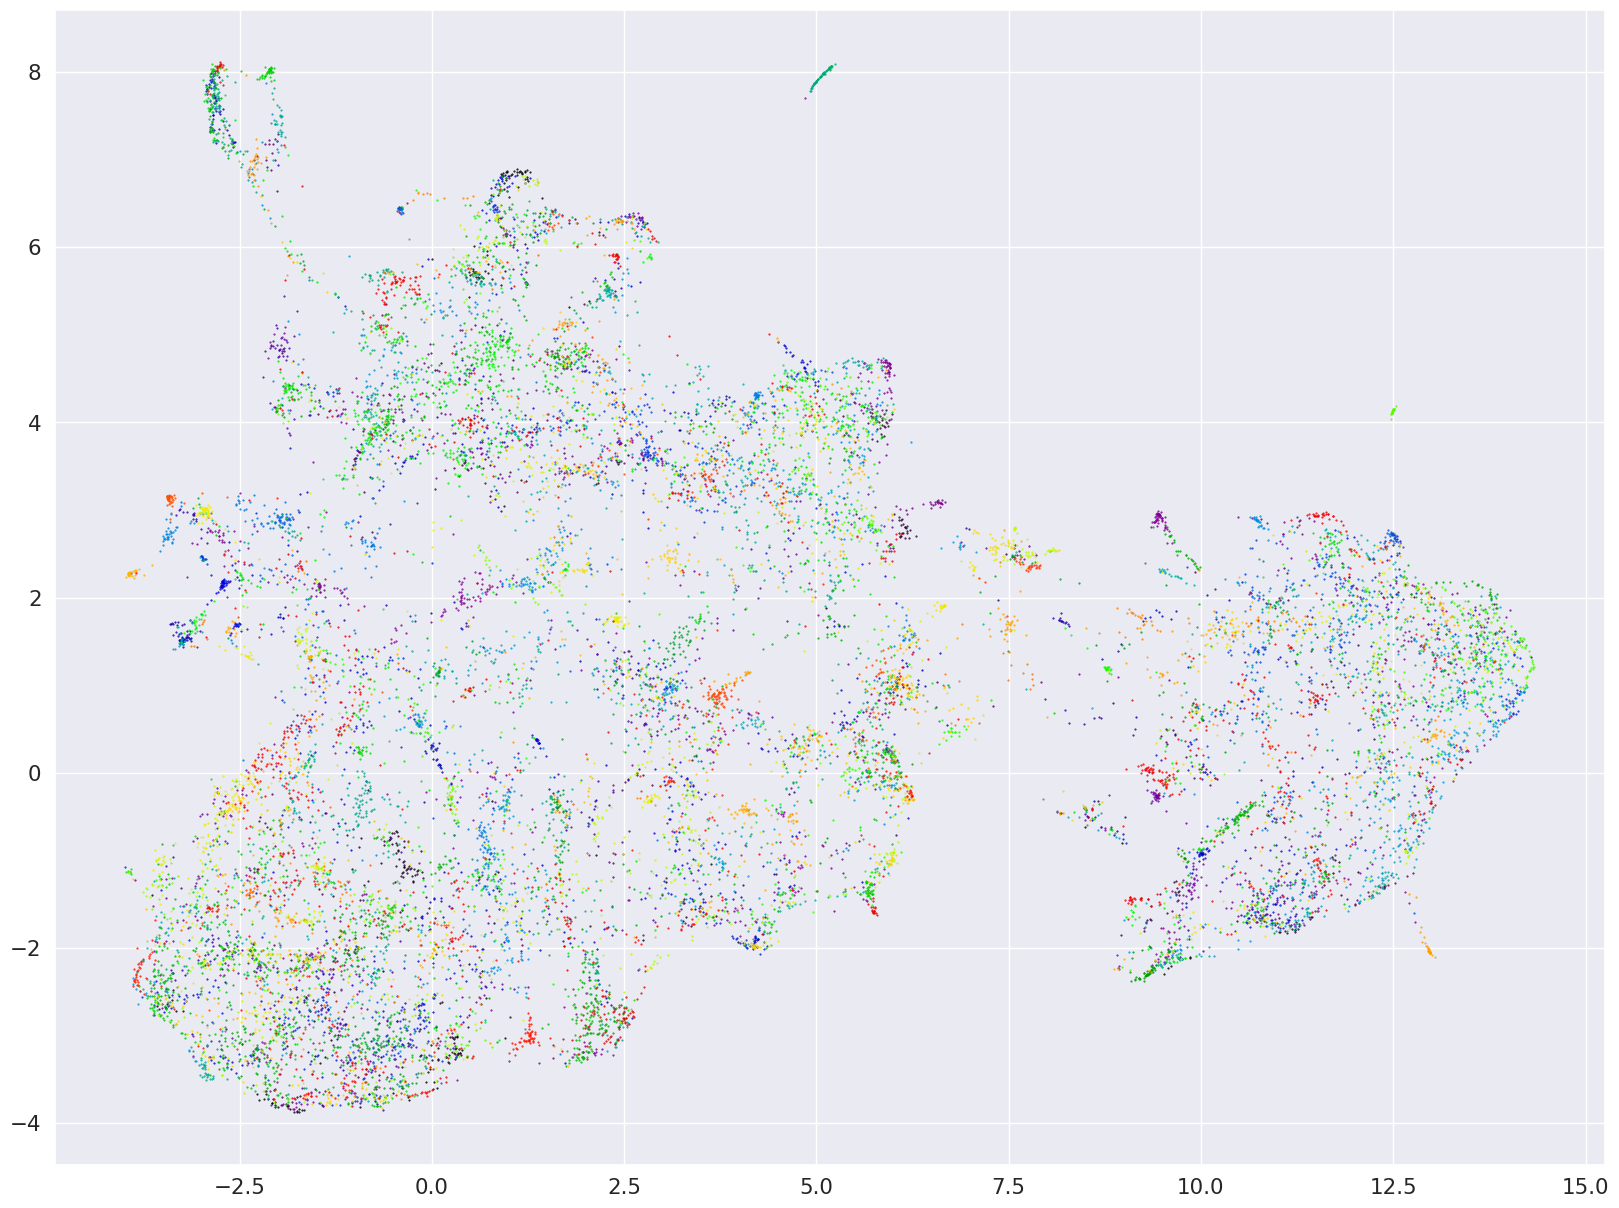

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.17923440563085954
INFO:PML:TRAINING EPOCH 6
total_loss=0.08626: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 6
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.37it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


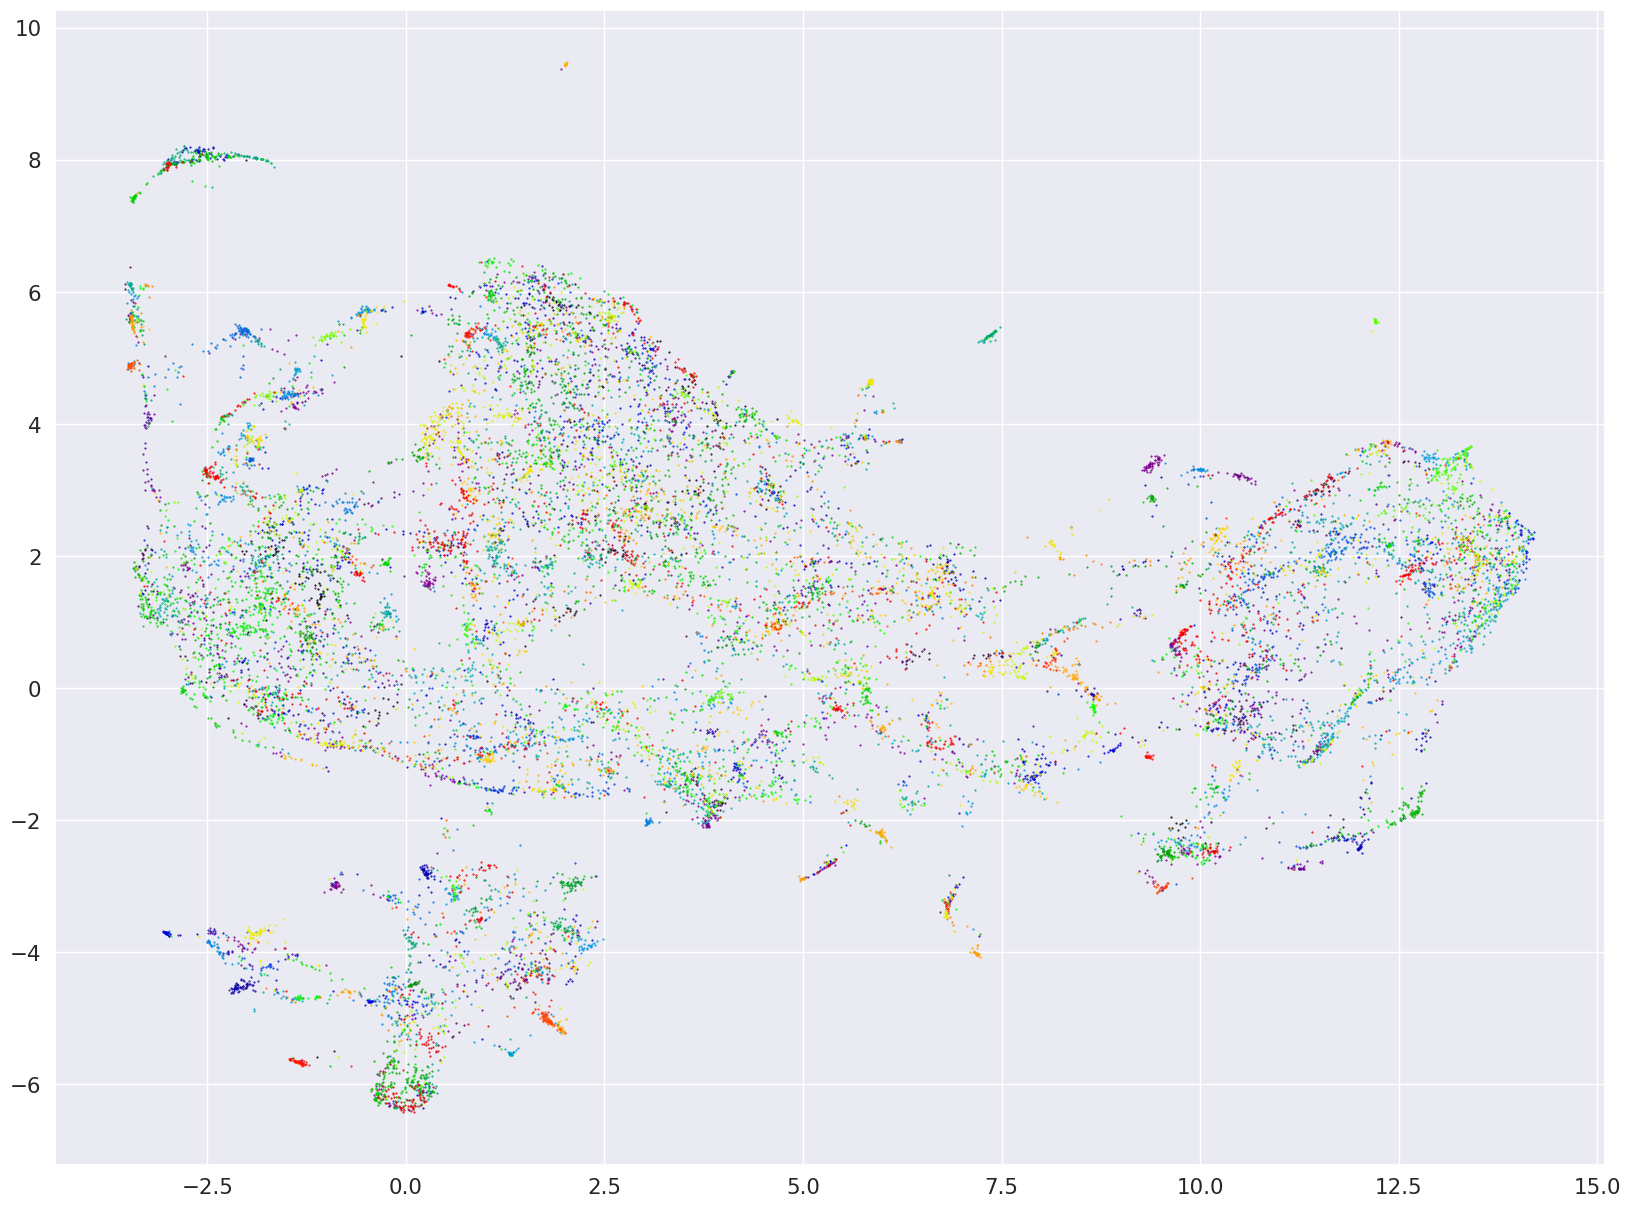

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.19950007383157076
INFO:PML:TRAINING EPOCH 7
total_loss=0.12177: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 7
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:45<00:00,  5.32it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


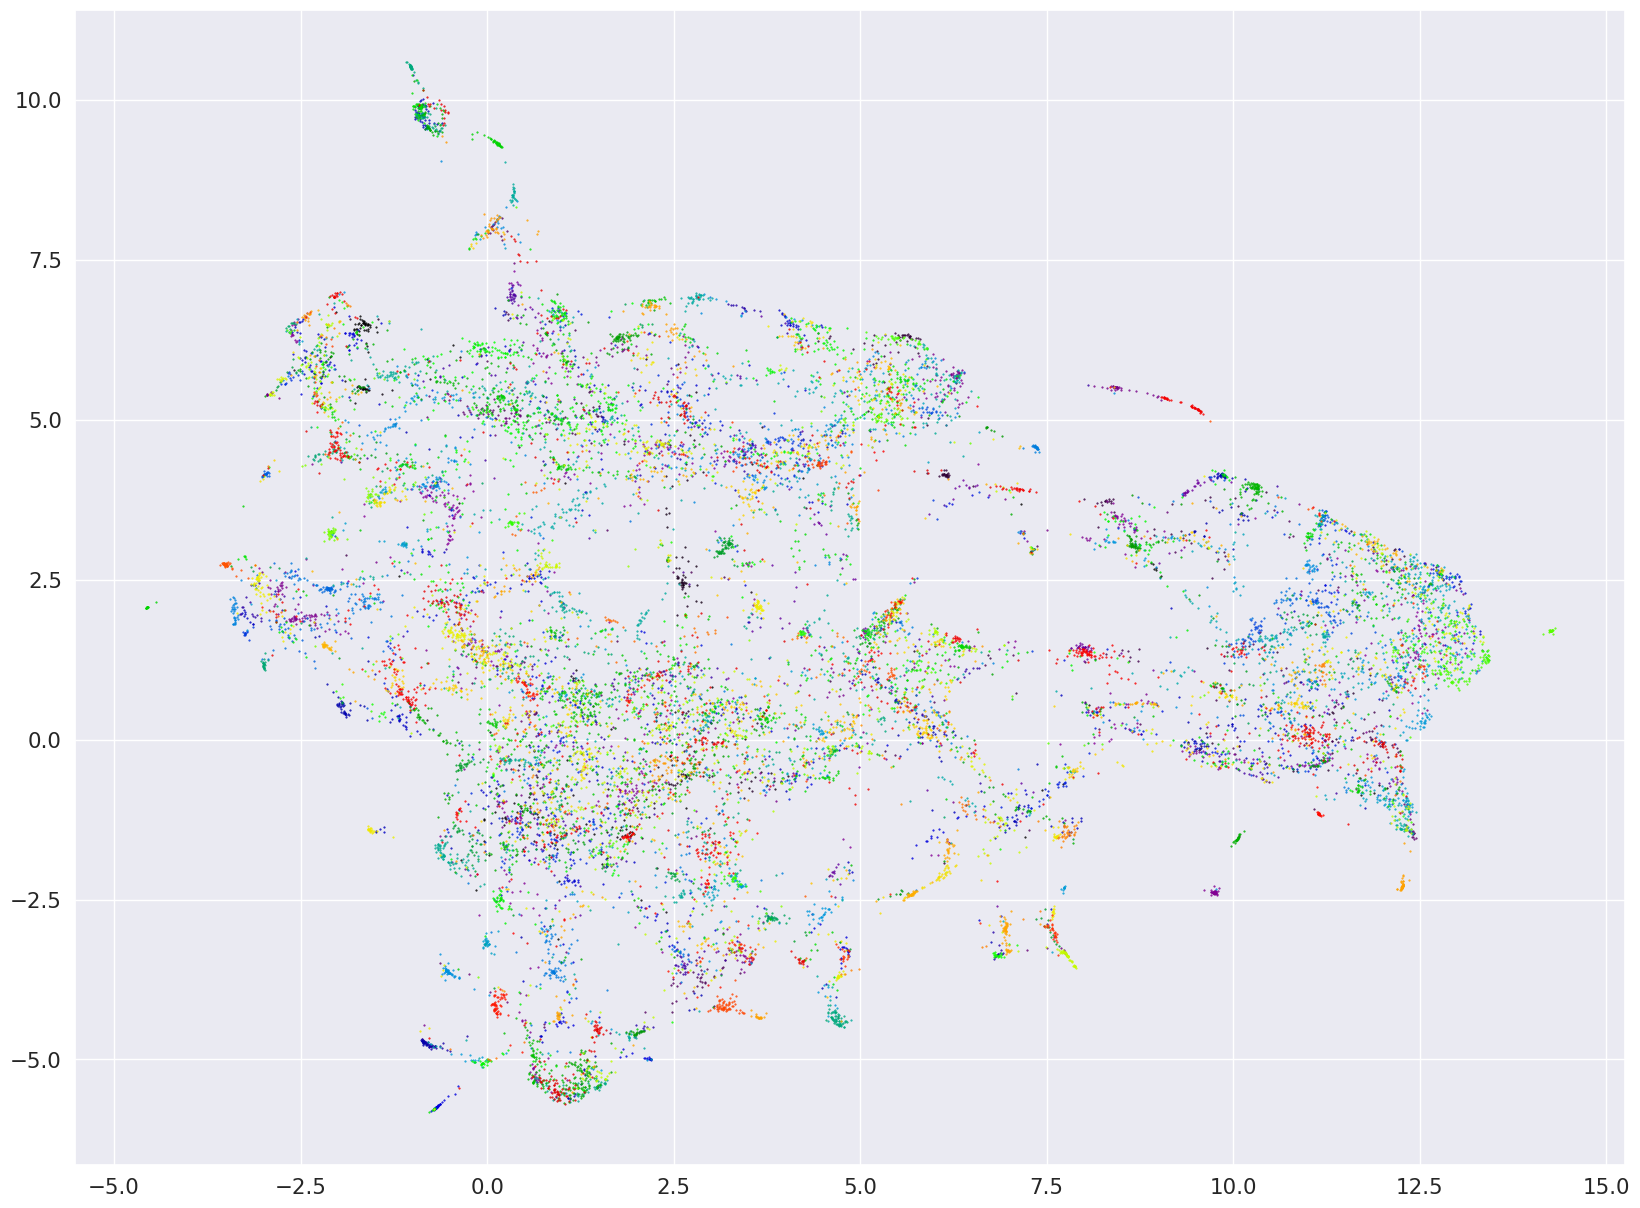

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:TRAINING EPOCH 8
total_loss=0.11187: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:58<00:00,  1.72it/s]
INFO:PML:Evaluating epoch 8
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.35it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


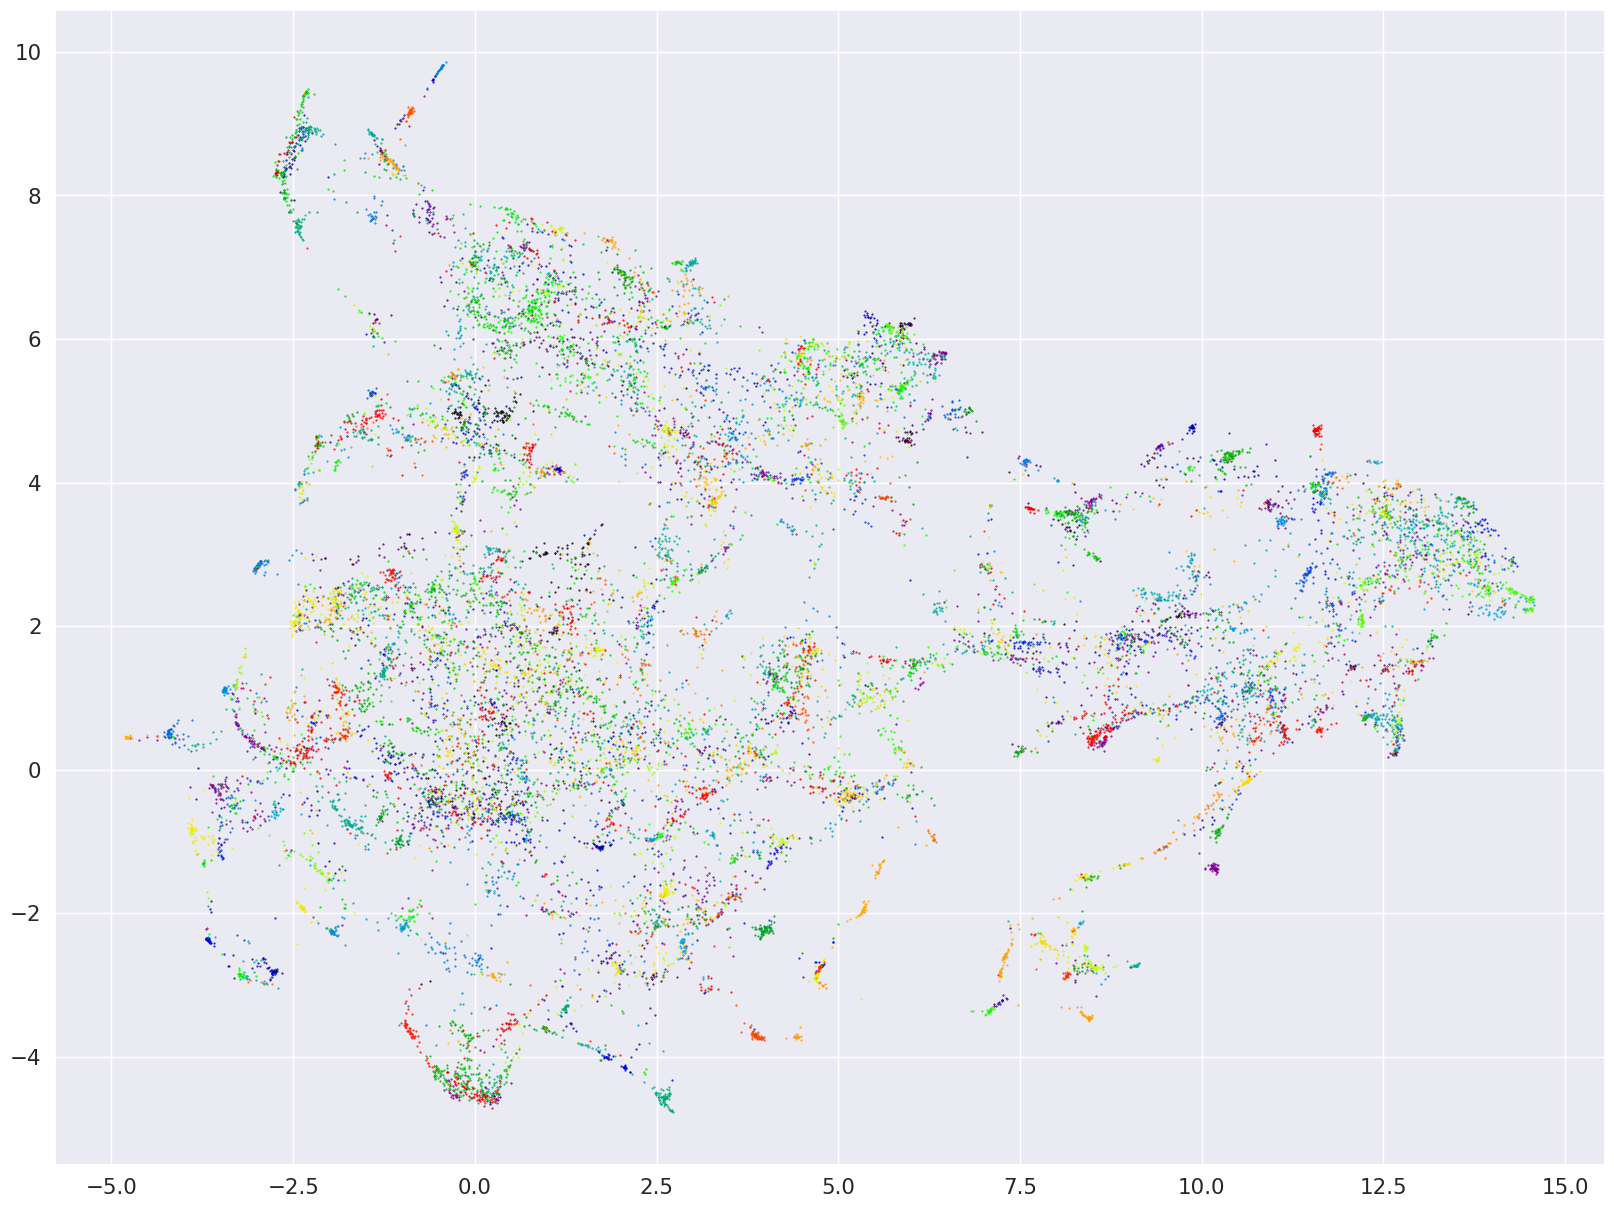

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.21683028522700962
INFO:PML:TRAINING EPOCH 9
total_loss=0.11755: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:52<00:00,  1.58it/s]
INFO:PML:Evaluating epoch 9
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.38it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


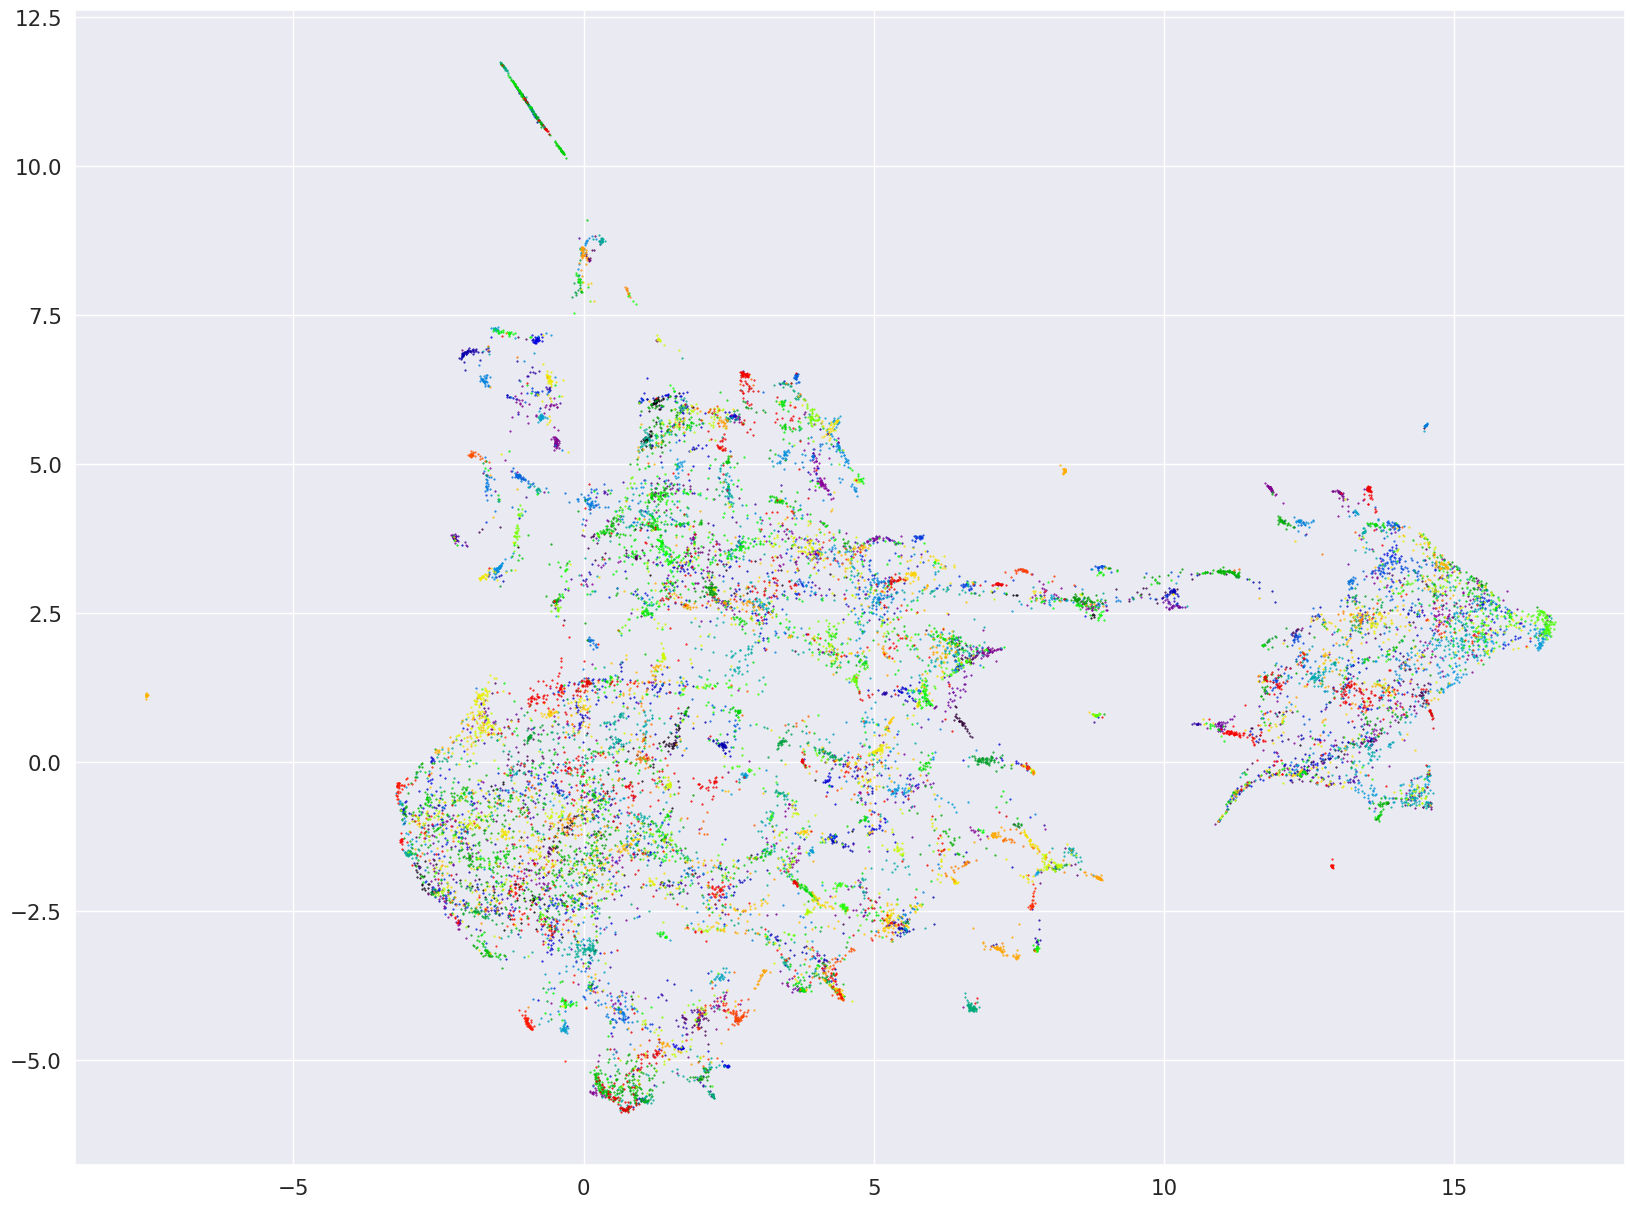

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.231156159732067
INFO:PML:TRAINING EPOCH 10
total_loss=0.09364: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:52<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 10
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:45<00:00,  5.33it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


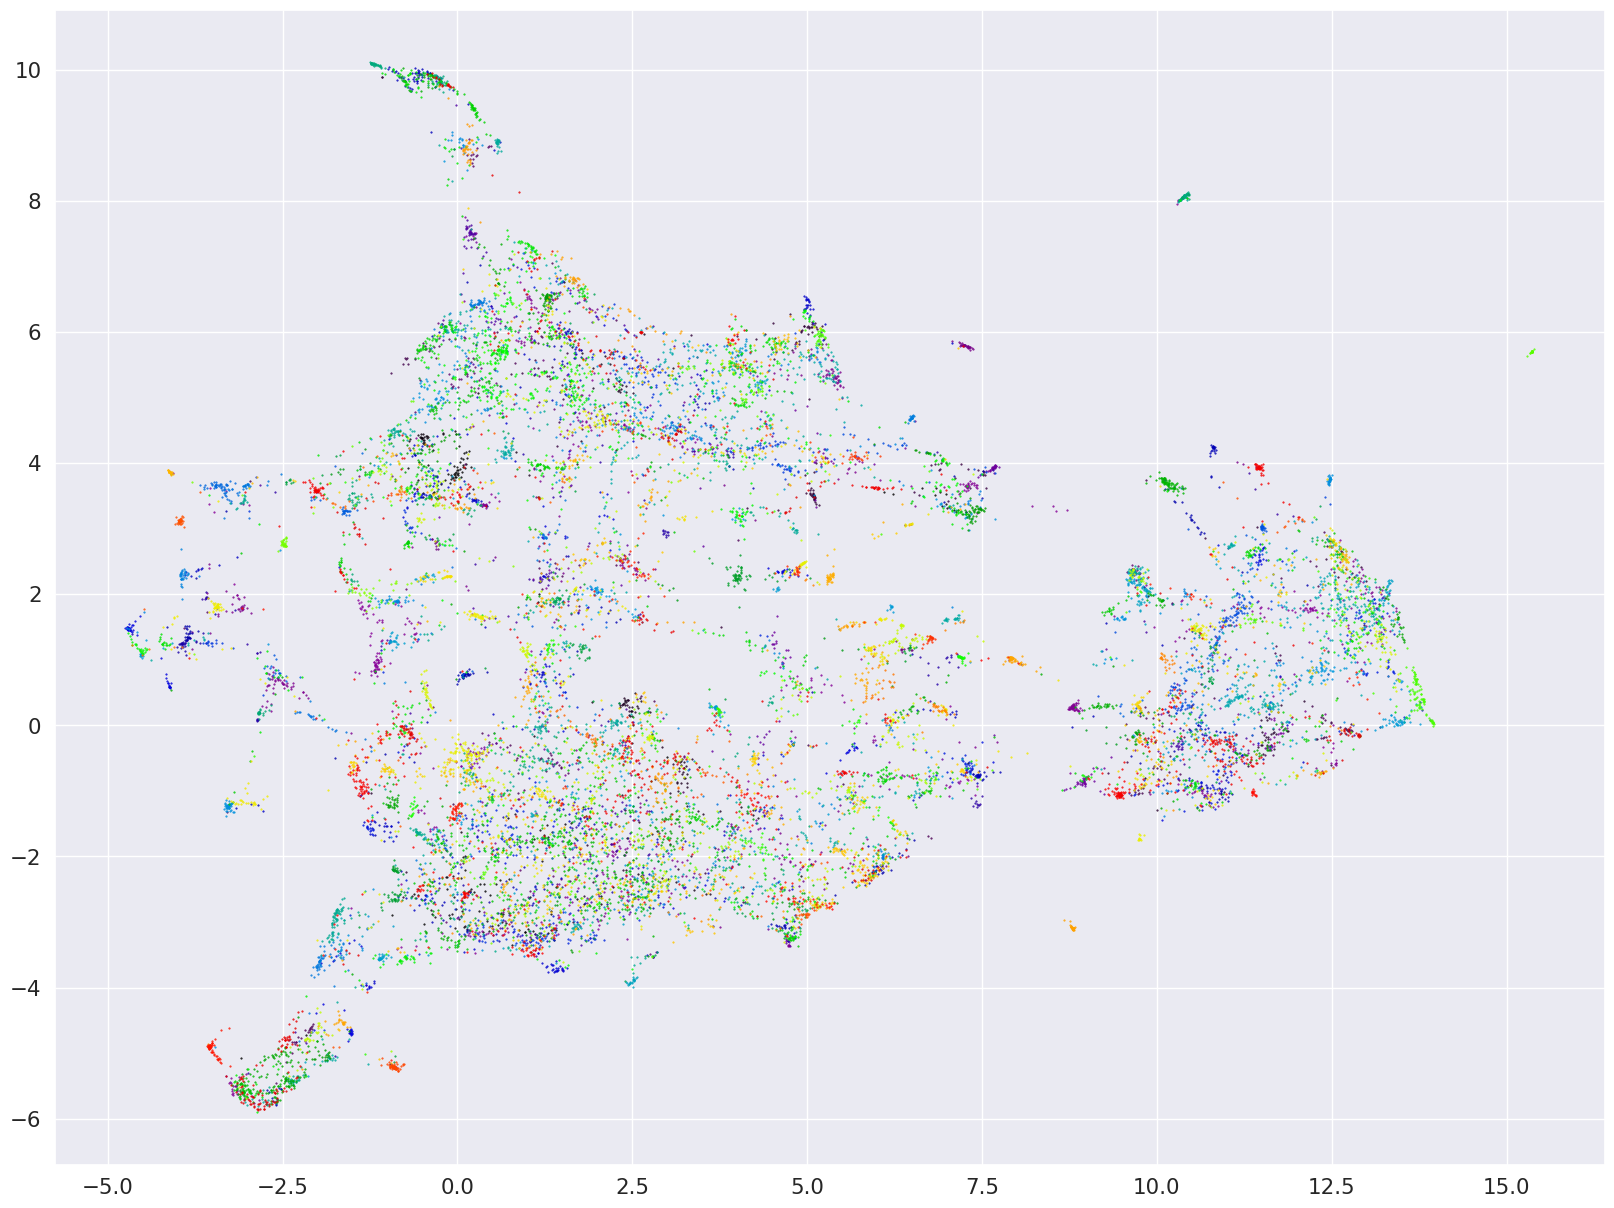

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:TRAINING EPOCH 11
total_loss=0.11330: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 11
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.36it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


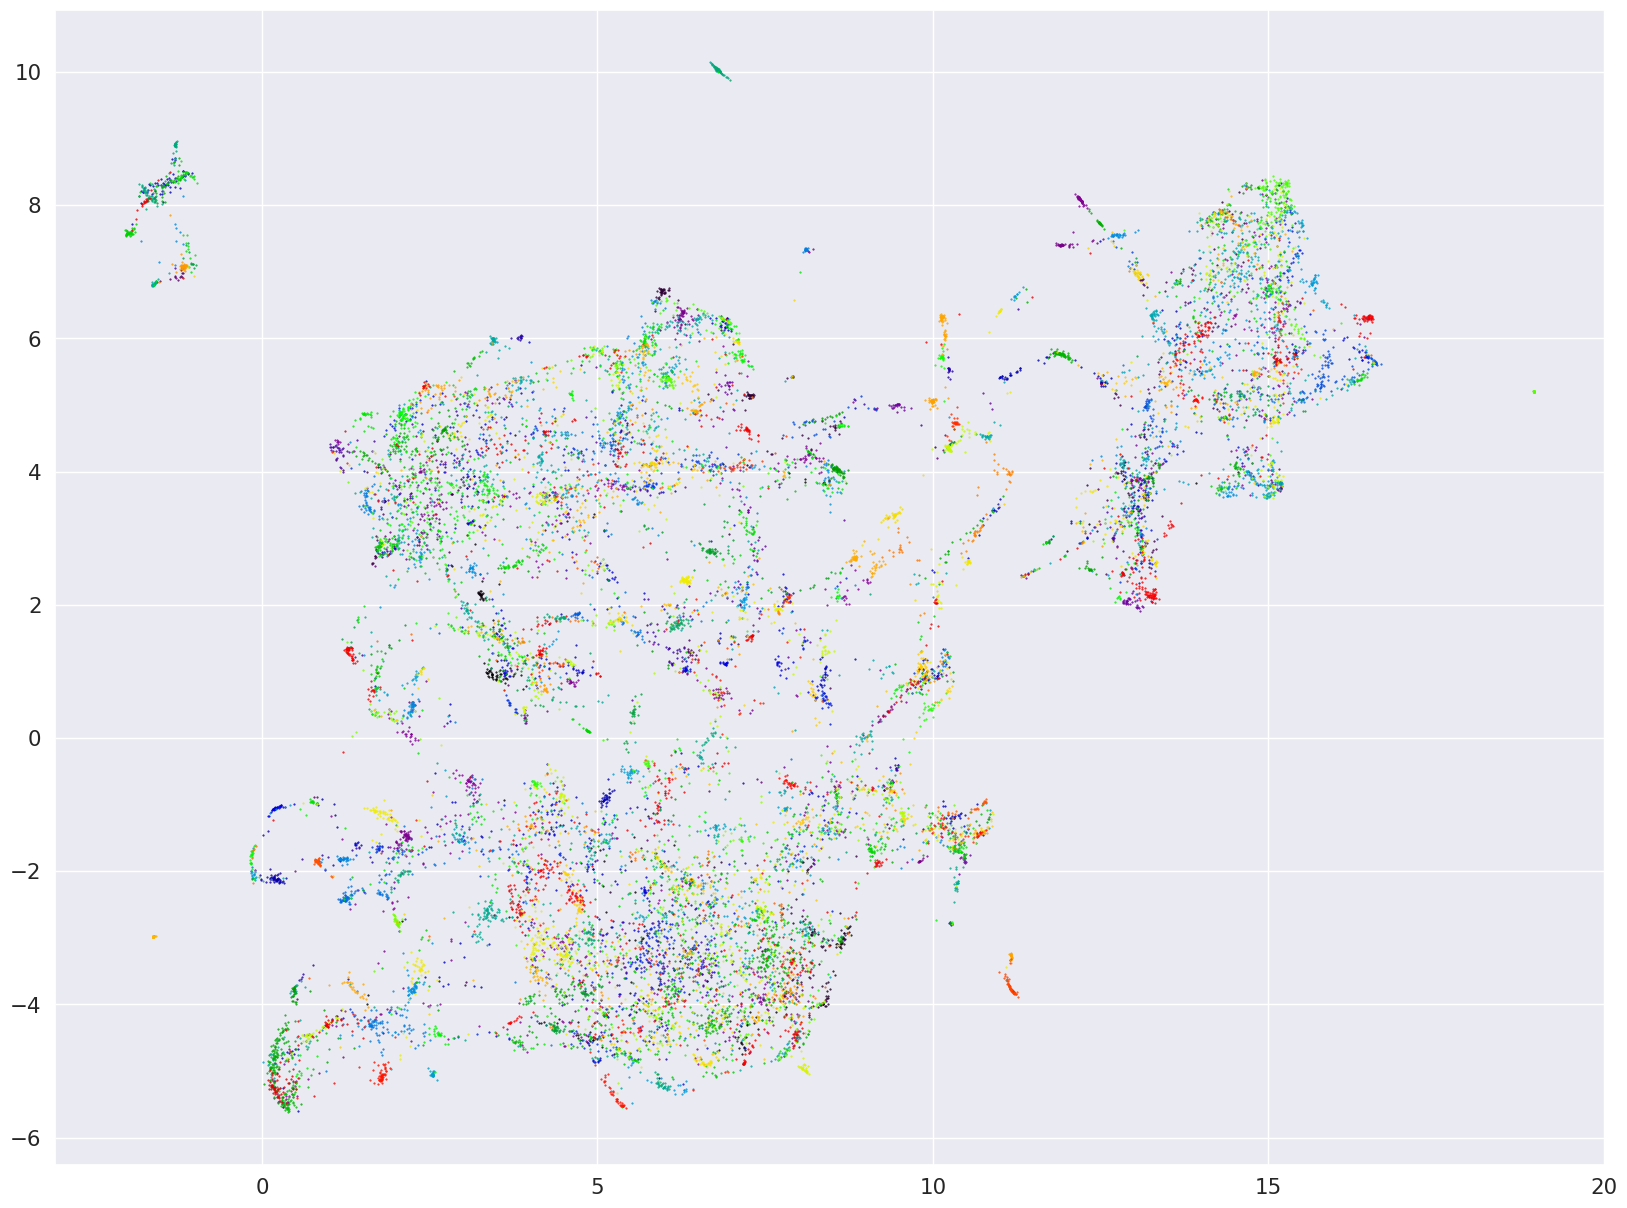

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:New best accuracy! 0.23799406909711607
INFO:PML:TRAINING EPOCH 12
total_loss=0.09552: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:53<00:00,  1.57it/s]
INFO:PML:Evaluating epoch 12
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:44<00:00,  5.38it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


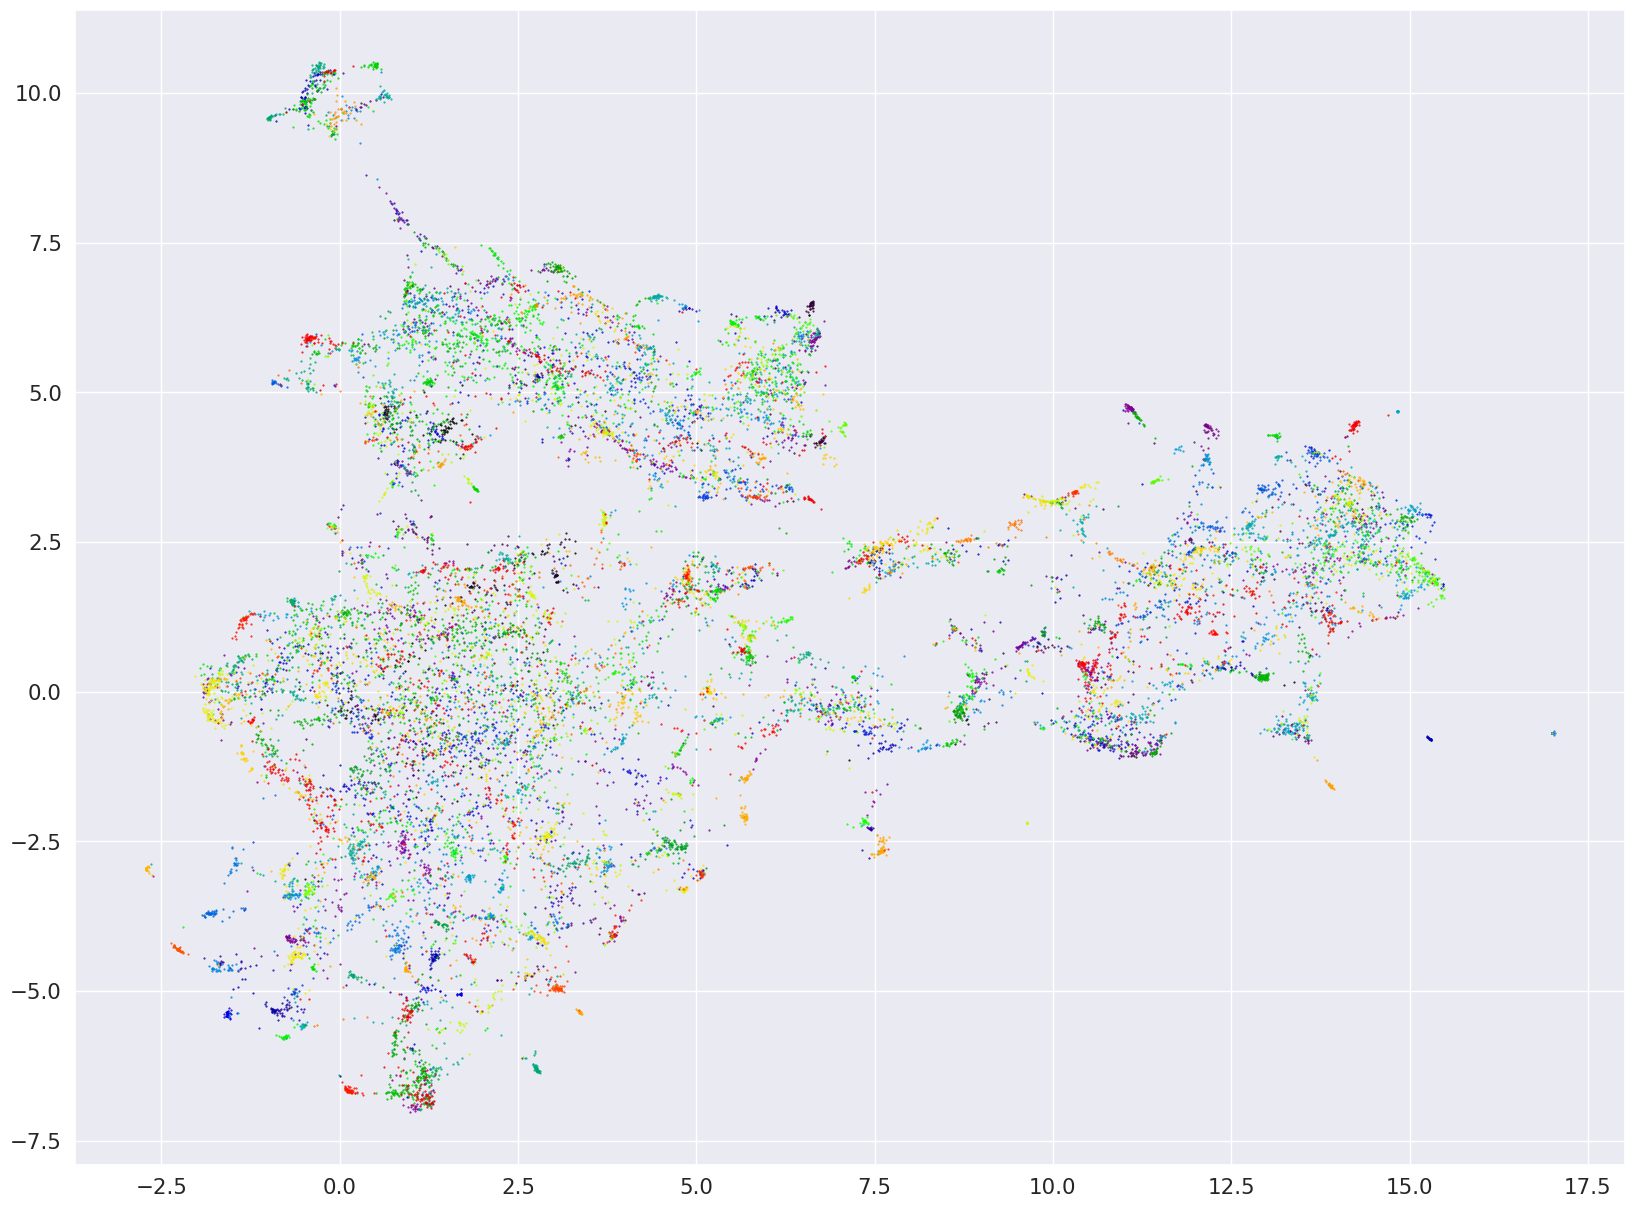

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:TRAINING EPOCH 13
total_loss=0.16135: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:52<00:00,  1.58it/s]
INFO:PML:Evaluating epoch 13
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:45<00:00,  5.35it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


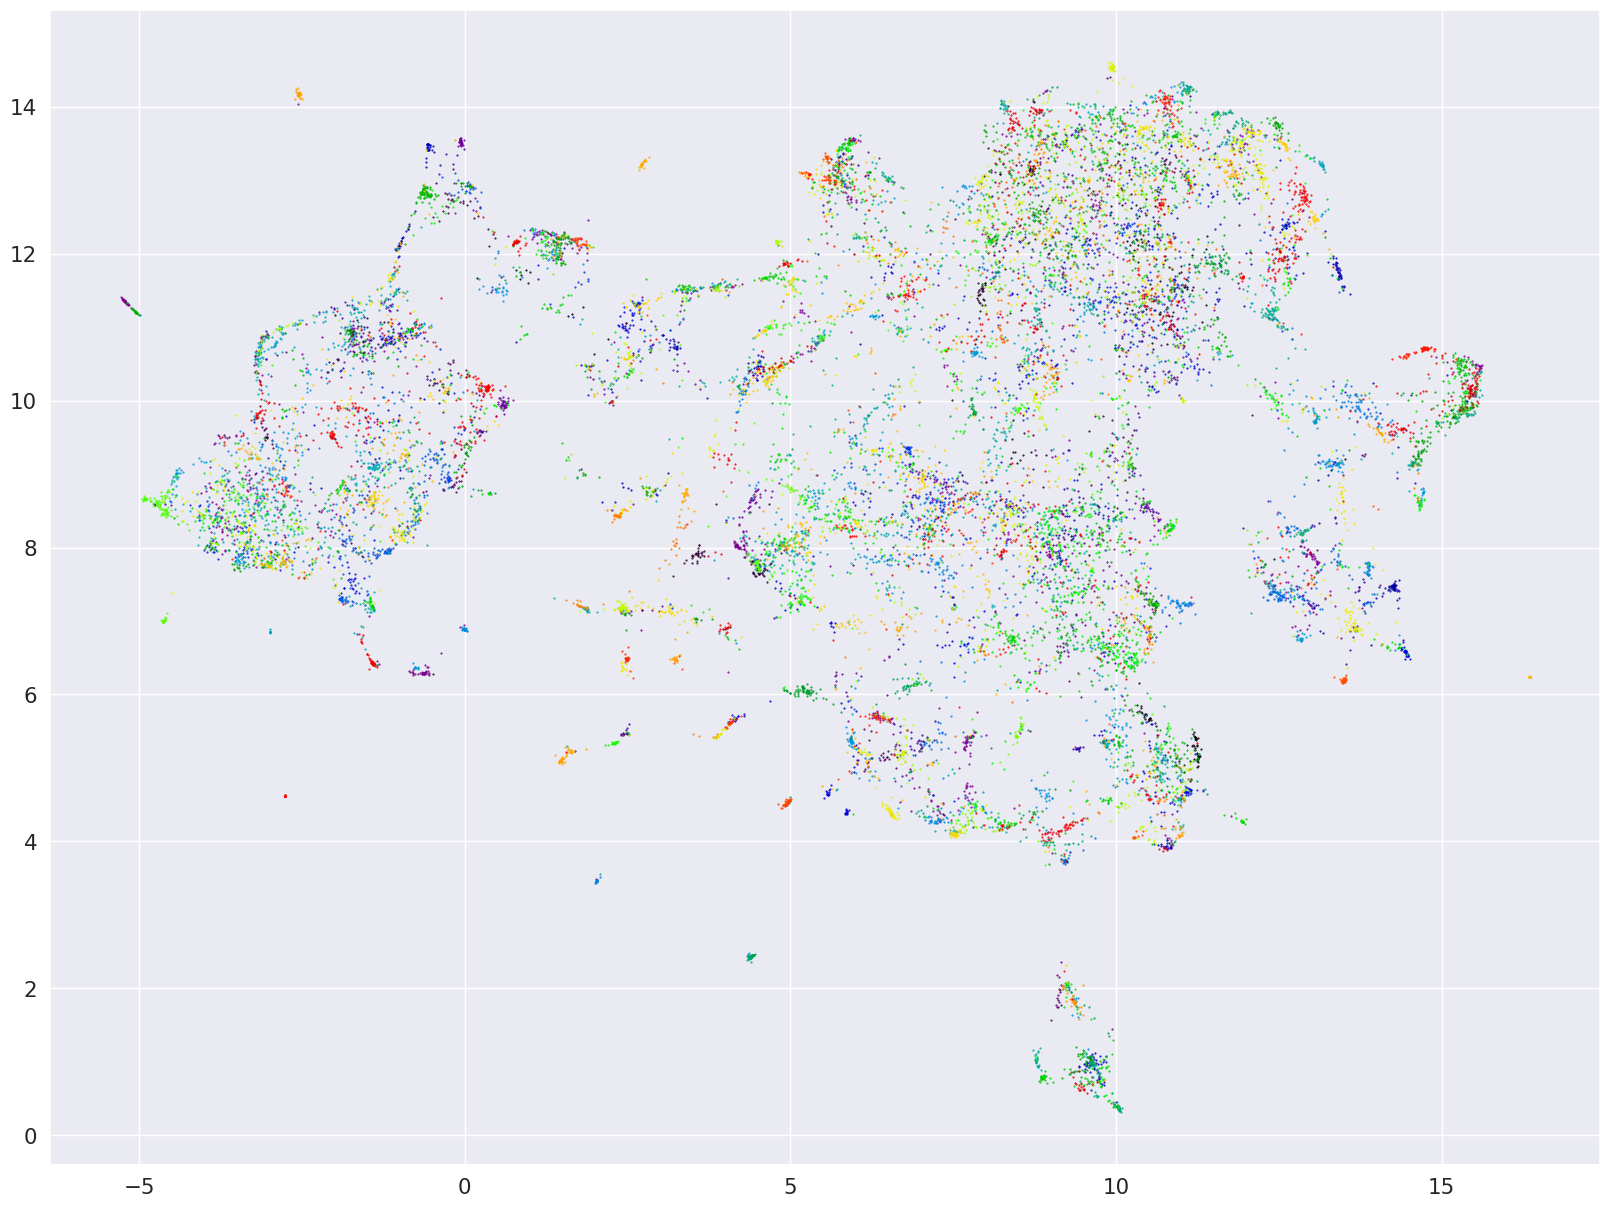

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 748
INFO:PML:Validation accuracy has plateaued. Exiting.


In [47]:
trainer.train(num_epochs=num_epochs)

In [ ]:
v13: logs_res50_0001lr_metric_only_mapr